In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import random

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [2]:
# Load CSV data into a DataFrame

data_path = "../data/data.csv"
columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 
           'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 
           'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 
           'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 
           'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
           'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 
           'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 
           'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 
           'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

df = pd.read_csv(data_path, header=None, names=columns)
print("Dataset shape:", df.shape)
df.head()
label_counts = df['label'].value_counts()
print(label_counts)


Dataset shape: (4898431, 42)
label
smurf.              2807886
neptune.            1072017
normal.              972781
satan.                15892
ipsweep.              12481
portsweep.            10413
nmap.                  2316
back.                  2203
warezclient.           1020
teardrop.               979
pod.                    264
guess_passwd.            53
buffer_overflow.         30
land.                    21
warezmaster.             20
imap.                    12
rootkit.                 10
loadmodule.               9
ftp_write.                8
multihop.                 7
phf.                      4
perl.                     3
spy.                      2
Name: count, dtype: int64


1. Preprocessing

Now I will classify two different type of data, categorical and continous. This is because each type of data have 
different way of encoding it. So we will encode it differently, then concat it to create a token that represent a row of
data.

In [3]:
categorical_cols = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
continuous_cols = [col for col in df.columns if col not in categorical_cols + ['label']]

In [4]:
#For continuous data, we will use normalisation 
scaler = StandardScaler()
df_cont = pd.DataFrame(scaler.fit_transform(df[continuous_cols]), columns=continuous_cols)

In [5]:
#For categorical data, since they r text, we will use label encoder
df_cat = df[categorical_cols].copy()
cat_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cat[col] = le.fit_transform(df_cat[col].astype(str))
    cat_encoders[col] = le

In [6]:
#Preprocessing the label
# Process target labels: first remove trailing punctuation if any (e.g., "normal." -> "normal")
df['label'] = df['label'].str.replace(r'\W+$', '', regex=True)
target_labels = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 
                 'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep', 
                 'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']


In [7]:
# Create label encoder for targets
target_le = LabelEncoder()
target_le.fit(target_labels)
df['label_enc'] = target_le.transform(df['label'])
print(target_le.classes_)



['back' 'buffer_overflow' 'ftp_write' 'guess_passwd' 'imap' 'ipsweep'
 'land' 'loadmodule' 'multihop' 'neptune' 'nmap' 'normal' 'perl' 'phf'
 'pod' 'portsweep' 'rootkit' 'satan' 'smurf' 'spy' 'teardrop'
 'warezclient' 'warezmaster']


In [8]:
# Combine continuous and categorical features
df_features = pd.concat([df_cont, df_cat], axis=1)
print("Processed features shape:", df_features.shape)
df_features.head()

Processed features shape: (4898431, 41)


,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,protocol_type,service,flag,land,logged_in,is_host_login,is_guest_login
0,-0.066833,-0.001720,0.068188,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
1,-0.066833,-0.001777,0.005325,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
2,-0.066833,-0.001698,0.000208,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
3,-0.066833,-0.001701,0.001455,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0
4,-0.066833,-0.001695,-0.000942,-0.015139,-0.001103,-0.026521,-0.004391,-0.002097,-0.008258,-0.004546,...,-0.465454,-0.250832,-0.249632,1,24,9,0,1,0,0


2. Create the model

My intention is using a transformer that have similar structure to BERT. This is because the model will have an attention layer to learn the semantic relationship between packets. The sliding allows
use to look at a range of packets in sequence, and look if there is suspicious packets in the sequence.

In [9]:
WINDOW_SIZE = 100
STRIDE = 100
class JumpingWindowDataset(Dataset):
    def __init__(self, features, labels, window_size, stride=None):
        """
        features: numpy array of shape (num_rows, num_features)
        labels: numpy array of shape (num_rows,)
        window_size: int, number of rows per window
        stride: int, how many steps to jump for each window (defaults to window_size for non-overlapping)
        """
        self.features = features
        self.labels = labels
        self.window_size = window_size
        self.stride = stride if stride is not None else window_size
        
        # Calculate number of windows
        self.num_windows = max(0, (len(features) - window_size) // self.stride + 1)
        
    def __len__(self):
        return self.num_windows
    
    def __getitem__(self, idx):
        # Calculate start and end indices for this window
        start_idx = idx * self.stride
        end_idx = start_idx + self.window_size
        
        # Extract window features and all labels within the window
        window_features = self.features[start_idx:end_idx]
        window_labels = self.labels[start_idx:end_idx]
        
        return torch.tensor(window_features, dtype=torch.float32), torch.tensor(window_labels, dtype=torch.long)

# Get the preprocessed feature and label arrays
features_np = df_features.values.astype(np.float32)
labels_np = df['label_enc'].values.astype(np.int64)
print("Original features shape:", features_np.shape)
print("Original labels shape:", labels_np.shape)

# Create the sliding window dataset
dataset = JumpingWindowDataset(features_np, labels_np, WINDOW_SIZE)
print("Sliding window dataset length:", len(dataset))

# Split the dataset into training and test sets using random_split
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) #originally batch_size = 32
test_loader = DataLoader(test_dataset, batch_size=32)

Original features shape: (4898431, 41)
Original labels shape: (4898431,)
Sliding window dataset length: 48984


In [10]:
class PacketTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim, num_layers, num_heads, window_size, num_classes):
        super(PacketTransformer, self).__init__()
        self.window_size = window_size
        
        # Project the input token (each packet) into an embedding
        self.input_proj = nn.Linear(input_dim, embed_dim)
        
        # Positional embeddings: one per token in the window
        self.pos_embedding = nn.Parameter(torch.randn(window_size, embed_dim))
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=0.1)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Classification head - will be applied to each token output
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.ReLU(),
            nn.Linear(embed_dim, num_classes)
        )
        
    def forward(self, x):
        """
        x: tensor of shape [batch, window_size, input_dim]
        """
        batch_size = x.size(0)
        
        # Project each token
        tokens = self.input_proj(x)  # [batch, window_size, embed_dim]
        
        # Add positional embedding
        tokens = tokens + self.pos_embedding.unsqueeze(0)
        
        # Transformer expects shape: [seq_len, batch, embed_dim]
        tokens = tokens.transpose(0, 1)
        transformer_out = self.transformer_encoder(tokens)
        
        # Transpose back to [batch, seq_len, embed_dim]
        transformer_out = transformer_out.transpose(0, 1)
        
        # Apply classifier to each token output
        logits = self.classifier(transformer_out)  # [batch, window_size, num_classes]
        
        return logits

In [11]:
input_dim = dataset.features.shape[-1]#X_Windows.shape[-1] #df_features.shape[-1]  # number of features per token
embed_dim = 16 #originally 64
num_layers = 1 #modify number of heads and layers original value =2 
num_heads = 2 # original value = 4
num_classes = len(target_labels)
num_epochs = 60

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = PacketTransformer(input_dim=input_dim, embed_dim=embed_dim, num_layers=num_layers,
                          num_heads=num_heads, window_size=WINDOW_SIZE, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Using device: cuda


c:\Users\Antoi\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    # Wrap loader with tqdm for progress bar
    for batch_X, batch_y in tqdm(loader, desc="Training", leave=False):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        
        # Get model output (batch_size, window_size, num_classes)
        logits = model(batch_X)
        
        # Reshape for loss calculation
        batch_size, window_size, num_classes = logits.shape
        logits_flat = logits.reshape(-1, num_classes)
        labels_flat = batch_y.view(-1)
        
        # Calculate loss
        loss = criterion(logits_flat, labels_flat)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0) * window_size
        
    # Return only the loss (to match original function signature)
    return running_loss / (len(loader.dataset) * WINDOW_SIZE)

In [13]:
def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch_X, batch_y in tqdm(loader, desc="Evaluating", leave=False):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            # Get model output
            logits = model(batch_X)
            
            # Reshape for loss calculation
            batch_size, window_size, num_classes = logits.shape
            logits_flat = logits.reshape(-1, num_classes)
            labels_flat = batch_y.view(-1)
            
            loss = criterion(logits_flat, labels_flat)
            
            # Calculate accuracy
            preds = logits_flat.argmax(dim=1)
            correct += (preds == labels_flat).sum().item()
            total += labels_flat.size(0)
            
            # Collect predictions and true labels for confusion matrix
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_flat.cpu().numpy())
            
            running_loss += loss.item() * batch_X.size(0) * window_size
    
    avg_loss = running_loss / (len(loader.dataset) * WINDOW_SIZE)
    avg_acc = correct / total
    
    return avg_loss, avg_acc, all_labels, all_preds

In [14]:
for epoch in range(1, num_epochs+1):
    print(f"Epoch {epoch}/{num_epochs}")
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, all_labels, all_preds = evaluate(model, test_loader, criterion, device)
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/60


Train Loss: 1.0636 | Val Loss: 0.1609 | Val Acc: 0.9901
Epoch 2/60


Train Loss: 0.1021 | Val Loss: 0.0548 | Val Acc: 0.9916
Epoch 3/60


Train Loss: 0.0472 | Val Loss: 0.0370 | Val Acc: 0.9944
Epoch 4/60


Train Loss: 0.0326 | Val Loss: 0.0305 | Val Acc: 0.9948
Epoch 5/60


Train Loss: 0.0251 | Val Loss: 0.0249 | Val Acc: 0.9956
Epoch 6/60


Train Loss: 0.0205 | Val Loss: 0.0215 | Val Acc: 0.9963
Epoch 7/60


Train Loss: 0.0176 | Val Loss: 0.0186 | Val Acc: 0.9968
Epoch 8/60


Train Loss: 0.0152 | Val Loss: 0.0171 | Val Acc: 0.9969
Epoch 9/60


Train Loss: 0.0136 | Val Loss: 0.0153 | Val Acc: 0.9973
Epoch 10/60


Train Loss: 0.0123 | Val Loss: 0.0150 | Val Acc: 0.9973
Epoch 11/60


Train Loss: 0.0112 | Val Loss: 0.0126 | Val Acc: 0.9977
Epoch 12/60


Train Loss: 0.0104 | Val Loss: 0.0122 | Val Acc: 0.9976
Epoch 13/60


Train Loss: 0.0095 | Val Loss: 0.0113 | Val Acc: 0.9977
Epoch 14/60


Train Loss: 0.0090 | Val Loss: 0.0119 | Val Acc: 0.9975
Epoch 15/60


Train Loss: 0.0084 | Val Loss: 0.0104 | Val Acc: 0.9979
Epoch 16/60


Train Loss: 0.0075 | Val Loss: 0.0102 | Val Acc: 0.9978
Epoch 17/60


Train Loss: 0.0072 | Val Loss: 0.0097 | Val Acc: 0.9979
Epoch 18/60


Train Loss: 0.0066 | Val Loss: 0.0095 | Val Acc: 0.9979
Epoch 19/60


Train Loss: 0.0062 | Val Loss: 0.0081 | Val Acc: 0.9982
Epoch 20/60


Train Loss: 0.0059 | Val Loss: 0.0081 | Val Acc: 0.9982
Epoch 21/60


Train Loss: 0.0055 | Val Loss: 0.0075 | Val Acc: 0.9984
Epoch 22/60


Train Loss: 0.0052 | Val Loss: 0.0078 | Val Acc: 0.9984
Epoch 23/60


Train Loss: 0.0048 | Val Loss: 0.0068 | Val Acc: 0.9986
Epoch 24/60


Train Loss: 0.0046 | Val Loss: 0.0069 | Val Acc: 0.9986
Epoch 25/60


Train Loss: 0.0044 | Val Loss: 0.0073 | Val Acc: 0.9986
Epoch 26/60


Train Loss: 0.0042 | Val Loss: 0.0063 | Val Acc: 0.9987
Epoch 27/60


Train Loss: 0.0040 | Val Loss: 0.0062 | Val Acc: 0.9987
Epoch 28/60


Train Loss: 0.0037 | Val Loss: 0.0068 | Val Acc: 0.9986
Epoch 29/60


Train Loss: 0.0036 | Val Loss: 0.0063 | Val Acc: 0.9987
Epoch 30/60


Train Loss: 0.0034 | Val Loss: 0.0058 | Val Acc: 0.9988
Epoch 31/60


Train Loss: 0.0033 | Val Loss: 0.0057 | Val Acc: 0.9989
Epoch 32/60


Train Loss: 0.0032 | Val Loss: 0.0052 | Val Acc: 0.9989
Epoch 33/60


Train Loss: 0.0030 | Val Loss: 0.0053 | Val Acc: 0.9989
Epoch 34/60


Train Loss: 0.0028 | Val Loss: 0.0049 | Val Acc: 0.9990
Epoch 35/60


Train Loss: 0.0027 | Val Loss: 0.0052 | Val Acc: 0.9990
Epoch 36/60


Train Loss: 0.0026 | Val Loss: 0.0049 | Val Acc: 0.9990
Epoch 37/60


Train Loss: 0.0025 | Val Loss: 0.0052 | Val Acc: 0.9989
Epoch 38/60


Train Loss: 0.0024 | Val Loss: 0.0049 | Val Acc: 0.9992
Epoch 39/60


Train Loss: 0.0023 | Val Loss: 0.0049 | Val Acc: 0.9991
Epoch 40/60


Train Loss: 0.0022 | Val Loss: 0.0045 | Val Acc: 0.9992
Epoch 41/60


Train Loss: 0.0022 | Val Loss: 0.0046 | Val Acc: 0.9992
Epoch 42/60


Train Loss: 0.0021 | Val Loss: 0.0044 | Val Acc: 0.9992
Epoch 43/60


Train Loss: 0.0020 | Val Loss: 0.0044 | Val Acc: 0.9992
Epoch 44/60


Train Loss: 0.0019 | Val Loss: 0.0048 | Val Acc: 0.9991
Epoch 45/60


Train Loss: 0.0019 | Val Loss: 0.0044 | Val Acc: 0.9992
Epoch 46/60


Train Loss: 0.0018 | Val Loss: 0.0041 | Val Acc: 0.9992
Epoch 47/60


Train Loss: 0.0017 | Val Loss: 0.0043 | Val Acc: 0.9992
Epoch 48/60


Train Loss: 0.0017 | Val Loss: 0.0042 | Val Acc: 0.9992
Epoch 49/60


Train Loss: 0.0016 | Val Loss: 0.0041 | Val Acc: 0.9992
Epoch 50/60


Train Loss: 0.0016 | Val Loss: 0.0039 | Val Acc: 0.9993
Epoch 51/60


Train Loss: 0.0015 | Val Loss: 0.0041 | Val Acc: 0.9993
Epoch 52/60


Train Loss: 0.0016 | Val Loss: 0.0044 | Val Acc: 0.9992
Epoch 53/60


Train Loss: 0.0014 | Val Loss: 0.0038 | Val Acc: 0.9993
Epoch 54/60


Train Loss: 0.0014 | Val Loss: 0.0043 | Val Acc: 0.9993
Epoch 55/60


Train Loss: 0.0013 | Val Loss: 0.0040 | Val Acc: 0.9993
Epoch 56/60


Train Loss: 0.0014 | Val Loss: 0.0038 | Val Acc: 0.9993
Epoch 57/60


Train Loss: 0.0013 | Val Loss: 0.0041 | Val Acc: 0.9993
Epoch 58/60


Train Loss: 0.0012 | Val Loss: 0.0040 | Val Acc: 0.9993
Epoch 59/60


Train Loss: 0.0012 | Val Loss: 0.0035 | Val Acc: 0.9993
Epoch 60/60


Train Loss: 0.0013 | Val Loss: 0.0039 | Val Acc: 0.9993


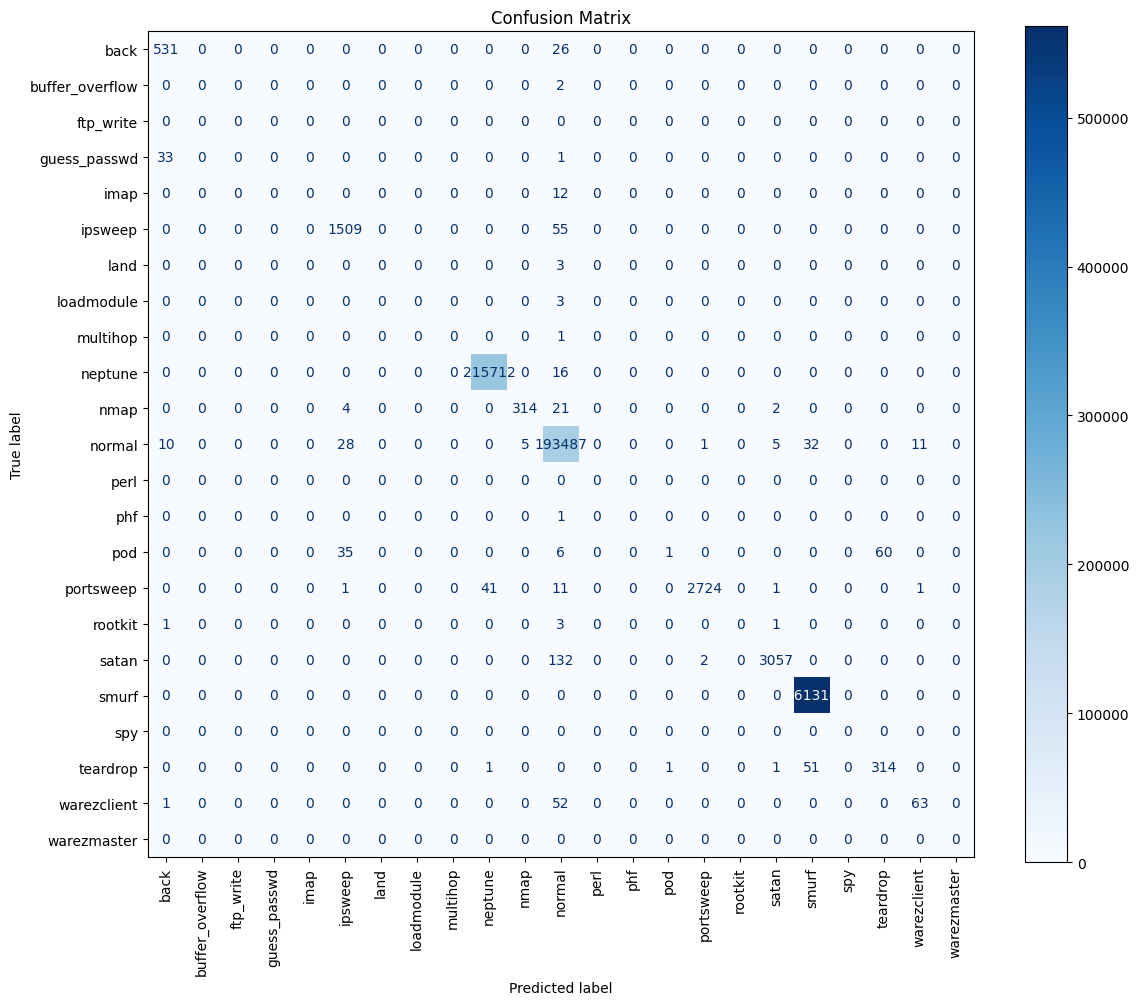

In [15]:
#colour scale is currently a bit strange

def compute_confusion_matrix(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X = batch_X.to(device)
            logits = model(batch_X)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(batch_y.cpu().numpy())
    return all_labels, all_preds

# Compute confusion matrix on test data
true_labels, pred_labels = compute_confusion_matrix(model, test_loader, device)
cm = confusion_matrix(all_labels, all_preds, labels=list(range(len(target_labels))))

# Create a larger figure
fig, ax = plt.subplots(figsize=(12, 10))  

# Pass 'ax=ax' to plot the confusion matrix on this figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

plt.title("Confusion Matrix")
plt.tight_layout()  # Helps reduce label overlap
plt.show()